# Basic unet
This is a bare bone U-net for some experiments with transfer learning

## Import libraries

In [1]:
!pip install seaborn
!pip install numba

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [3]:
from numba import cuda 
device = cuda.get_current_device()
#device.reset()
device

<weakproxy at 0x7fb50199d9a0 to Device at 0x7fb501995400>

In [7]:
import os
import imageio.v2 as imageio
from skimage.transform import resize # For preprocessing
import tensorflow as tf

#gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

2023-09-07 08:58:09.573081: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


docker run -it --rm -p 8882:8882 --gpus device=0:0 -v /mnt/Extension_100TB/William/GitHub/Detection-of-hunting-pits-using-airborne-laser-scanning-and-deep-learning:/workspace/code -v /mnt/Extension_100TB/William/Projects/Cultural_remains/data:/workspace/data -v /mnt/Extension_100TB/national_datasets/laserdataskog/:/workspace/lidar segmentation:latest bash

cd /workspace/code/notebooks/

jupyter lab --ip=0.0.0.0 --port=8882 --allow-root --no-browser --NotebookApp.allow_origin='*'


# Train model without pre-training

## Read data from disk

In [156]:
%%time
tf.keras.utils.set_random_seed(2)
IMG_WIDTH = 256 # the original images are 250x250. 
IMG_HEIGHT = 256
IMG_CHANNELS = 1 # a grey scale image only has one band for color.
NUM_CLASSES = 1 # 0 = no crater and 1 = crater

#### Training data ####
TRAIN_PATH = '/workspace/data/final_data_05m/training/'
IMG_DIR = 'hillshade'
GT_DIR = 'labels'
X_train_pit = []
Y_train_pit = []

# load from disk
img_path = os.path.join(TRAIN_PATH, IMG_DIR)
gt_path = os.path.join(TRAIN_PATH, GT_DIR)
for image in (os.listdir(img_path)):
    img = imageio.imread(os.path.join(img_path, image))

    img = resize(img, (IMG_WIDTH, IMG_HEIGHT,1), mode='constant', preserve_range=True)
    
    mask = imageio.imread(os.path.join(gt_path, image))
    mask = resize(mask, (IMG_WIDTH, IMG_HEIGHT, 1), preserve_range=True, order=0).astype(int)
    
    X_train_pit.append(img)
    Y_train_pit.append(mask)

#### Test data ####
TEST_PATH = '/workspace/data/final_data_05m/testing/'
IMG_DIR = 'hillshade'
GT_DIR = 'labels'
X_test_pit = []
Y_test_pit = []

# load from disk
img_path = os.path.join(TEST_PATH, IMG_DIR)
gt_path = os.path.join(TEST_PATH, GT_DIR)
for image in (os.listdir(img_path)):
    img = imageio.imread(os.path.join(img_path, image))
    img = resize(img, (IMG_WIDTH, IMG_HEIGHT,1), mode='constant', preserve_range=True)
    mask = imageio.imread(os.path.join(gt_path, image))
    mask = resize(mask, (IMG_WIDTH, IMG_HEIGHT, 1), preserve_range=True, order=0).astype(int)
    
    X_test_pit.append(img)
    Y_test_pit.append(mask)

# convert list of numpy arrays into tensorflow dataset for further processing
train_images_pit = tf.data.Dataset.from_tensor_slices((X_train_pit, Y_train_pit))
test_images_pit = tf.data.Dataset.from_tensor_slices((X_test_pit, Y_test_pit))

CPU times: user 3min 2s, sys: 3.4 s, total: 3min 6s
Wall time: 3min 17s


In [215]:
print(len(train_images_pit))

1336


## Set up pipelines to preload data

In [158]:
BATCH_SIZE = 16
BUFFER_SIZE = 128

# training
train_batches_pit  = (train_images_pit 
                    .cache() # cache data
                    .shuffle(BUFFER_SIZE) # fill buffer, sample from it and replace with new items (buffer size > training set for perfect shuffling)
                    .batch(BATCH_SIZE)  
                    .repeat() 
                    .prefetch(buffer_size=128))
# testing
test_batches_pit  = (test_images_pit  
                    .cache() # cache data
                    .shuffle(BUFFER_SIZE) # fill buffer, sample from it and replace with new items (buffer size > training set for perfect shuffling)
                    .batch(BATCH_SIZE)  
                    .repeat(1)  # repeat dataset idefinetely
                    .prefetch(buffer_size=128)) 


## Add f1-score as a metric to monitor

In [159]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Basic U-net

In [179]:
#Build the model

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
NUM_CLASSES = 1

#Contraction path
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1) # to prevent overfitting
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(NUM_CLASSES, (1, 1))(c9)

model_pit = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model_pit.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=3, from_logits=True), metrics=['acc', f1_m, precision_m, recall_m])

## Train the model

84

In [181]:
%%time
steps_per_epoch_pit = round((len(train_images_pit)) / BATCH_SIZE)
result0 = model_pit.fit(train_batches_pit,validation_data=test_batches_pit, epochs=50,steps_per_epoch=steps_per_epoch_pit)

Epoch 1/50
84/84 [==============================] - 11s 116ms/step - loss: 0.0417 - acc: 0.9537 - f1_m: 0.0017 - precision_m: 0.0038 - recall_m: 0.0402 - val_loss: 0.0088 - val_acc: 0.9945 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/50
84/84 [==============================] - 9s 112ms/step - loss: 0.0080 - acc: 0.9946 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.0082 - val_acc: 0.9945 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/50
84/84 [==============================] - 9s 112ms/step - loss: 0.0076 - acc: 0.9946 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.0078 - val_acc: 0.9945 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/50
84/84 [==============================] - 9s 112ms/step - loss: 0.0073 - acc: 0.9946 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_lo

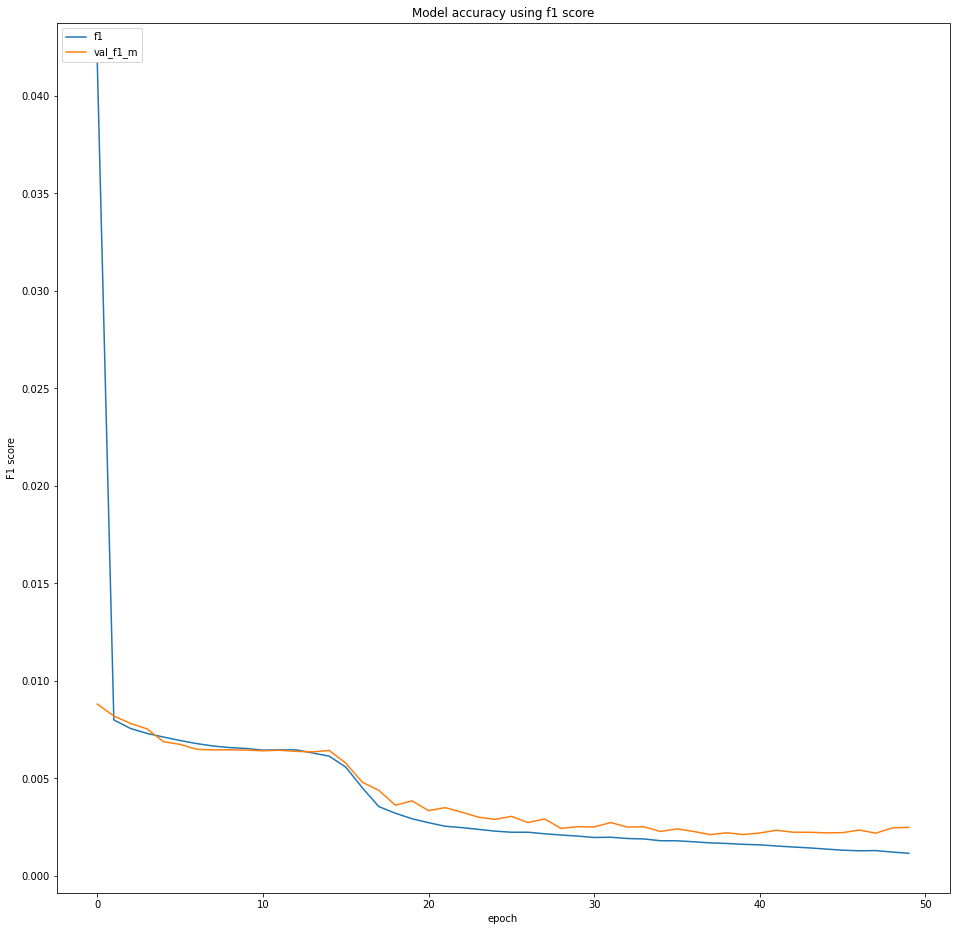

In [182]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(result0.history['loss'])
plt.plot(result0.history['val_loss'])
#plt.plot(result0.history['f1_m'])
#plt.plot(result0.history['val_f1_m'])
plt.title('Model accuracy using f1 score')
plt.ylabel('F1 score')
plt.xlabel('epoch')
#plt.ylim(0,0.01)
plt.legend(['f1', 'val_f1_m'], loc='upper left')
plt.show()

In [183]:
results = model_pit.evaluate(test_batches_pit)

21/21 [==============================] - 1s 36ms/step - loss: 0.0025 - acc: 0.9955 - f1_m: 0.3292 - precision_m: 0.9100 - recall_m: 0.2037


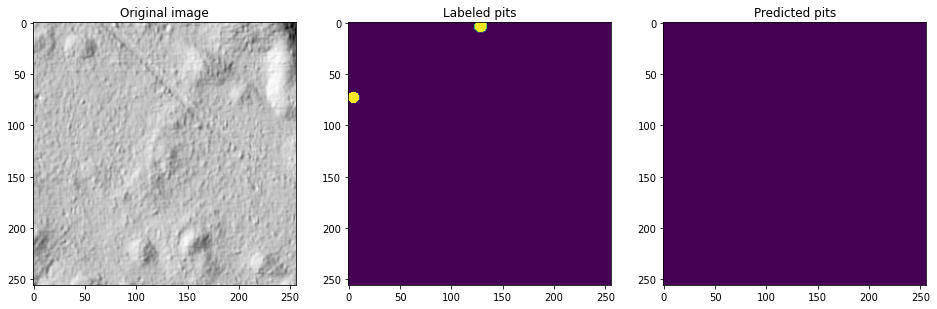

In [184]:
# size of plot
import numpy as np
import random
plt.rcParams['figure.figsize'] = [16, 16]
f, axarr = plt.subplots(1,3)
#i = random.randint(0, 300)
i = 14
#image 
testimage = X_test_pit[i]
orgimage = np.squeeze(testimage)

# label
testlabel = Y_test_pit[i]
testlabel = np.squeeze(testlabel)

# prediction
testimage = X_test_pit[i]
testimage = np.reshape(testimage,[1,256,256,1])
prediction_pit = model_pit.predict(testimage)
pred_pit = np.squeeze(prediction_pit)


# Image
axarr[0].set_title('Original image')
axarr[0].imshow(orgimage, cmap='Greys_r')

# Label
axarr[1].set_title('Labeled pits')
axarr[1].imshow(testlabel)

# Prediction
axarr[2].set_title('Predicted pits')
axarr[2].imshow(pred_pit>0.5)

# Train a model on the moon

In [14]:
%%time
import os
import imageio.v2 as imageio
from skimage.transform import resize # For preprocessing
import tensorflow as tf
tf.keras.utils.set_random_seed(0)



IMG_WIDTH = 256 # nr pixels
IMG_HEIGHT = 256
IMG_CHANNELS = 1 # a grey scale image only has one band for color.
NUM_CLASSES = 1 # 0 = no crater and 1 = crater

#### Training data ####
TRAIN_PATH = '/workspace/data/lunar_data/final_data/training/'
IMG_DIR = 'hillshade'
GT_DIR = 'labels'
X_train = []
Y_train = []

# load from disk
img_path = os.path.join(TRAIN_PATH, IMG_DIR)
gt_path = os.path.join(TRAIN_PATH, GT_DIR)
for image in (os.listdir(img_path)):
    img = imageio.imread(os.path.join(img_path, image))

    img = resize(img, (IMG_WIDTH, IMG_HEIGHT,1), mode='constant', preserve_range=True)
    
    mask = imageio.imread(os.path.join(gt_path, image))
    mask = resize(mask, (IMG_WIDTH, IMG_HEIGHT, 1), preserve_range=True, order=0).astype(int)
    
    X_train.append(img)
    Y_train.append(mask)


# convert list of numpy arrays into tensorflow dataset for further processing
train_images_moon = tf.data.Dataset.from_tensor_slices((X_train, Y_train))


CPU times: user 46min 36s, sys: 40.9 s, total: 47min 17s
Wall time: 49min 8s


In [185]:
BATCH_SIZE = 16
BUFFER_SIZE = 128

# training
train_batches_moon = (train_images_moon 
                    .cache() # cache data
                    .shuffle(BUFFER_SIZE) # fill buffer, sample from it and replace with new items (buffer size > training set for perfect shuffling)
                    .batch(BATCH_SIZE)  
                    .repeat() 
                    .prefetch(buffer_size=128))


In [186]:

steps_per_epoch_moon = round((len(train_images_moon)) / BATCH_SIZE)
steps_per_epoch_moon

1496

In [187]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
NUM_CLASSES = 1
#Contraction path
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1) # to prevent overfitting
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(NUM_CLASSES, (1, 1))(c9)

model_moon = tf.keras.Model(inputs=[inputs], outputs=[outputs])

model_moon.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=3.0, from_logits=True), metrics=['acc'])

## Set different weights for the moon

In [188]:
%%time 
result_moon = model_moon.fit(train_batches_moon, epochs=50, steps_per_epoch=steps_per_epoch_moon)


Epoch 1/50
1496/1496 [==============================] - 149s 99ms/step - loss: 0.0292 - acc: 0.9530
Epoch 2/50
1496/1496 [==============================] - 149s 100ms/step - loss: 0.0282 - acc: 0.9531
Epoch 3/50
1496/1496 [==============================] - 149s 100ms/step - loss: 0.0201 - acc: 0.9543
Epoch 4/50
1496/1496 [==============================] - 148s 99ms/step - loss: 0.0184 - acc: 0.9558
Epoch 5/50
1496/1496 [==============================] - 149s 100ms/step - loss: 0.0174 - acc: 0.9567
Epoch 6/50
1496/1496 [==============================] - 149s 100ms/step - loss: 0.0167 - acc: 0.9574
Epoch 7/50
1496/1496 [==============================] - 149s 100ms/step - loss: 0.0161 - acc: 0.9580
Epoch 8/50
1496/1496 [==============================] - 148s 99ms/step - loss: 0.0155 - acc: 0.9585
Epoch 9/50
1496/1496 [==============================] - 149s 100ms/step - loss: 0.0149 - acc: 0.9590
Epoch 10/50
1496/1496 [==============================] - 150s 100ms/step - loss: 0.0144 - acc:

In [189]:
model_moon.save("/workspace/code/models/moon_hillshade.h5")

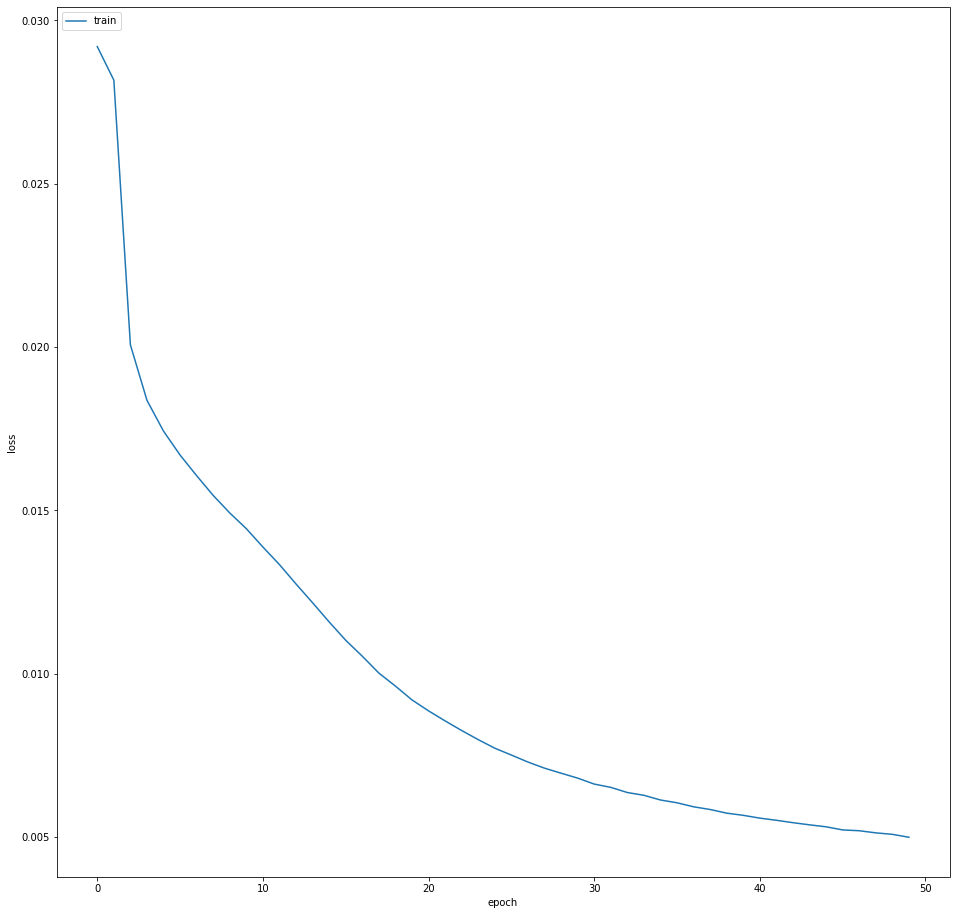

In [192]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(result_moon.history['loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Fine tune the moon model on hunting pits

In [193]:
import keras
from keras.models import Model
reconstructed_model = keras.models.load_model("/workspace/code/models/moon_hillshade.h5")# load old model



reconstructed_model.compile(
    tf.keras.optimizers.Adam(learning_rate=0.0001),
                            loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=3.0, from_logits=True),
                            metrics=['acc', f1_m, recall_m])

In [204]:
#result_pretrained = reconstructed_model.fit(train_batches.map(add_sample_weights),validation_data=test_batches_pit, epochs=50, steps_per_epoch=20)
#result_pretrained = reconstructed_model.fit(train_batches_pit,validation_data=test_batches_pit, epochs=25,steps_per_epoch=83)
result_pretrained2 = reconstructed_model.fit(train_batches_pit,validation_data=test_batches_pit, epochs=50,steps_per_epoch=83)

Epoch 1/50
83/83 [==============================] - 9s 113ms/step - loss: 5.1804e-04 - acc: 0.9977 - f1_m: 0.7307 - recall_m: 0.5873 - val_loss: 0.0032 - val_acc: 0.9963 - val_f1_m: 0.5560 - val_recall_m: 0.4219
Epoch 2/50
83/83 [==============================] - 9s 114ms/step - loss: 5.0705e-04 - acc: 0.9977 - f1_m: 0.7343 - recall_m: 0.5914 - val_loss: 0.0032 - val_acc: 0.9962 - val_f1_m: 0.5286 - val_recall_m: 0.3888
Epoch 3/50
83/83 [==============================] - 9s 114ms/step - loss: 5.0485e-04 - acc: 0.9977 - f1_m: 0.7282 - recall_m: 0.5844 - val_loss: 0.0033 - val_acc: 0.9962 - val_f1_m: 0.5197 - val_recall_m: 0.3783
Epoch 4/50
83/83 [==============================] - 9s 113ms/step - loss: 5.1187e-04 - acc: 0.9977 - f1_m: 0.7357 - recall_m: 0.5939 - val_loss: 0.0031 - val_acc: 0.9963 - val_f1_m: 0.5719 - val_recall_m: 0.4485
Epoch 5/50
83/83 [==============================] - 9s 113ms/step - loss: 4.8274e-04 - acc: 0.9978 - f1_m: 0.7482 - recall_m: 0.6093 - val_loss: 0.0035 

In [214]:
reconstructed_model.save("/workspace/code/models/transfer_hillshade.h5")
results_pretrained = reconstructed_model.evaluate(test_batches_pit)

21/21 [==============================] - 1s 38ms/step - loss: 0.0062 - acc: 0.9964 - f1_m: 0.5860 - recall_m: 0.4658


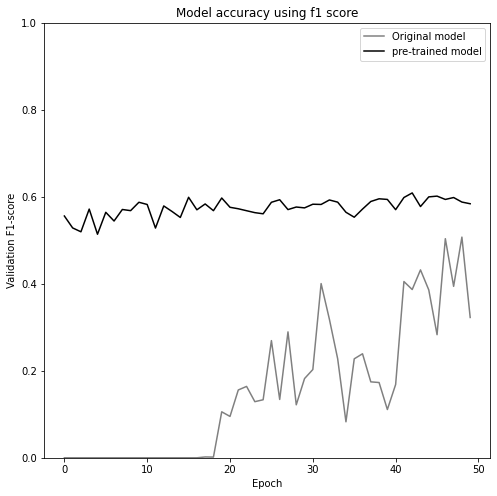

In [219]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]
#plt.plot(result0.history['f1_m'],color="grey")
plt.plot(result0.history['val_f1_m'],color="grey")
#plt.plot(result_pretrained2.history['f1_m'],color="limegreen")
plt.plot(result_pretrained2.history['val_f1_m'],color="black")


plt.title('Model accuracy using f1 score')
#

plt.ylabel('Validation F1-score')
plt.xlabel('Epoch')
plt.legend(['Original model','pre-trained model'], loc='upper right')
#plt.legend(['Original f1m','Original val f1m', 'pre-trained f1m','pre-trained val f1m'], loc='upper right')
plt.ylim(0,1)
#plt.xlim(0,200)
plt.show()

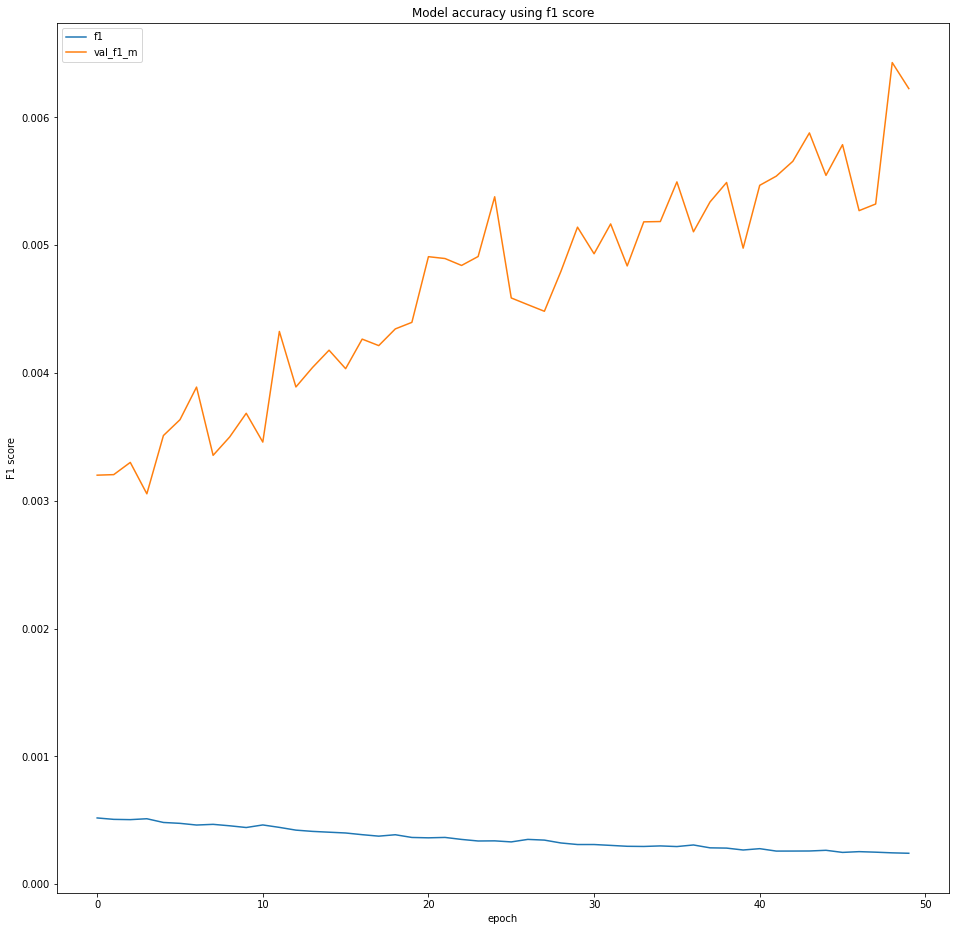

In [212]:
import matplotlib.pyplot as plt
plt.plot(result_pretrained2.history['loss'])
plt.plot(result_pretrained2.history['val_loss'])
#plt.plot(result0.history['f1_m'])
#plt.plot(result0.history['val_f1_m'])
plt.title('Model accuracy using f1 score')
plt.ylabel('F1 score')
plt.xlabel('epoch')
#plt.ylim(0,0.01)
plt.legend(['f1', 'val_f1_m'], loc='upper left')
plt.show()

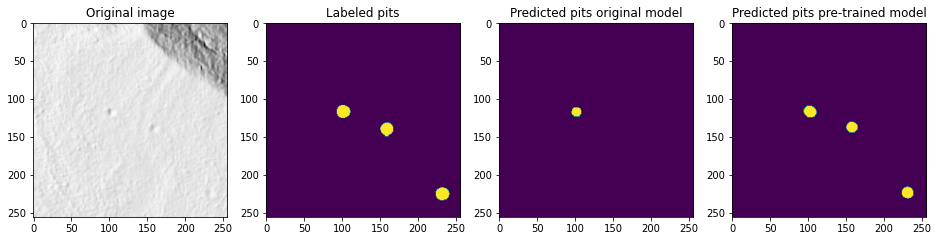

In [209]:
# size of plot
import numpy as np
import random
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.figsize'] = [16, 16]
f, axarr = plt.subplots(1,4)
#i = random.randint(0, 300)
i = 297
#image 
testimage = X_test_pit[i]
orgimage = np.squeeze(testimage)

# label
testlabel = Y_test_pit[i]
testlabel = np.squeeze(testlabel)

# prediction from original model
testimage = X_test_pit[i]
testimage = np.reshape(testimage,[1,256,256,1])
prediction1 = model_pit.predict(testimage)
pred1 = np.squeeze(prediction1)

# prediction
prediction2 = reconstructed_model.predict(testimage)
pred2 = np.squeeze(prediction2)


# Image
axarr[0].set_title('Original image')
axarr[0].imshow(orgimage, cmap='Greys_r')

# Label
axarr[1].set_title('Labeled pits')
axarr[1].imshow(testlabel)

# Prediction
axarr[2].set_title('Predicted pits original model')
axarr[2].imshow(pred1>0.5)

# Prediction
axarr[3].set_title('Predicted pits pre-trained model')
axarr[3].imshow(pred2>0.5)

In [199]:
#297
i

297

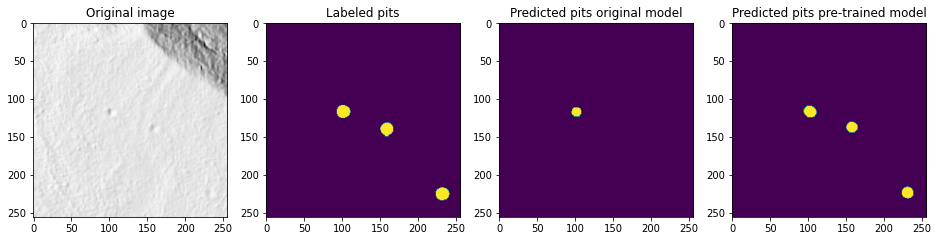

In [210]:
# size of plot
import numpy as np
import random
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.figsize'] = [16, 16]
f, axarr = plt.subplots(1,4)
#i = random.randint(0, 300)
i = 297
#image 
testimage = X_test_pit[i]
orgimage = np.squeeze(testimage)

# label
testlabel = Y_test_pit[i]
testlabel = np.squeeze(testlabel)

# prediction from original model
testimage = X_test_pit[i]
testimage = np.reshape(testimage,[1,256,256,1])
prediction1 = model_pit.predict(testimage)
pred1 = np.squeeze(prediction1)

# prediction
prediction2 = reconstructed_model.predict(testimage)
pred2 = np.squeeze(prediction2)


# Image
axarr[0].set_title('Original image')
axarr[0].imshow(orgimage, cmap='Greys_r')

# Label
axarr[1].set_title('Labeled pits')
axarr[1].imshow(testlabel)

# Prediction
axarr[2].set_title('Predicted pits original model')
axarr[2].imshow(pred1>0.5)

# Prediction
axarr[3].set_title('Predicted pits pre-trained model')
axarr[3].imshow(pred2>0.5)

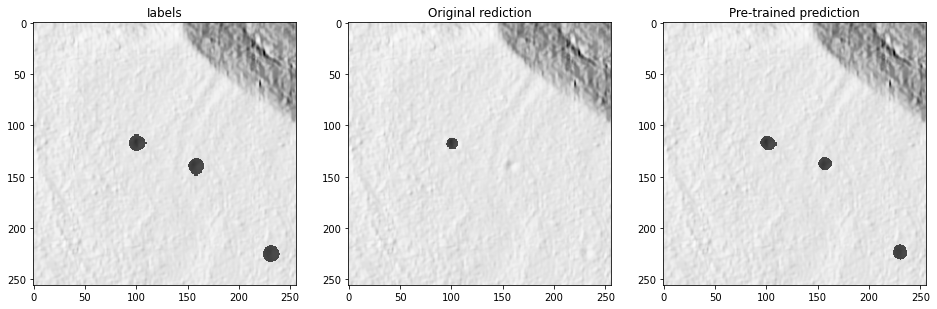

In [220]:
from matplotlib import colors
comap = colors.ListedColormap(['black'])

plt.rcParams['figure.figsize'] = [16, 16]
f, axarr = plt.subplots(1,3)

axarr[0].set_title('Iabels')
axarr[0].imshow(orgimage, cmap='Greys_r')
testlabel = np.ma.masked_where(testlabel < 0.5, testlabel)
axarr[0].imshow(testlabel, alpha=0.7,cmap=comap)

axarr[1].set_title('Original rediction')
pred1 = np.ma.masked_where(pred1 < 0.5, pred1)
axarr[1].imshow(orgimage, cmap='Greys_r')
axarr[1].imshow((pred1>0.5), alpha=0.7, cmap=comap)


axarr[2].set_title('Pre-trained prediction')
axarr[2].imshow(orgimage, cmap='Greys_r')

pred2 = np.ma.masked_where(pred2 < 0.5, pred2)
axarr[2].imshow(orgimage, cmap='Greys_r')
axarr[2].imshow(pred2, alpha=0.7, cmap=comap)# = np.ma.masked_where(pred2 < 0.5, pred2))


## Test stability

In [143]:
import keras
tf.keras.utils.set_random_seed(4)
from keras.models import Model
reconstructed_model = keras.models.load_model("/workspace/code/models/moon_minimal_hillshade.h5")# load old model
reconstructed_model.compile(
    tf.keras.optimizers.Adam(learning_rate=0.0001),
                            loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, from_logits=True),
                            metrics=['acc', f1_m, recall_m])

result_pretrained_4 = reconstructed_model.fit(train_batches_pit,validation_data=test_batches_pit, epochs=100, steps_per_epoch=83)

Epoch 1/100
83/83 [==============================] - 8s 83ms/step - loss: 0.0109 - acc: 0.9897 - f1_m: 0.1385 - recall_m: 0.0787 - val_loss: 0.0088 - val_acc: 0.9893 - val_f1_m: 0.0991 - val_recall_m: 0.0528
Epoch 2/100
83/83 [==============================] - 7s 80ms/step - loss: 0.0081 - acc: 0.9905 - f1_m: 0.2809 - recall_m: 0.1757 - val_loss: 0.0081 - val_acc: 0.9896 - val_f1_m: 0.1508 - val_recall_m: 0.0824
Epoch 3/100
83/83 [==============================] - 7s 80ms/step - loss: 0.0073 - acc: 0.9909 - f1_m: 0.3167 - recall_m: 0.1996 - val_loss: 0.0076 - val_acc: 0.9900 - val_f1_m: 0.2190 - val_recall_m: 0.1249
Epoch 4/100
83/83 [==============================] - 7s 80ms/step - loss: 0.0067 - acc: 0.9910 - f1_m: 0.3275 - recall_m: 0.2074 - val_loss: 0.0076 - val_acc: 0.9902 - val_f1_m: 0.2442 - val_recall_m: 0.1422
Epoch 5/100
83/83 [==============================] - 7s 80ms/step - loss: 0.0063 - acc: 0.9911 - f1_m: 0.3378 - recall_m: 0.2161 - val_loss: 0.0076 - val_acc: 0.9905 - 

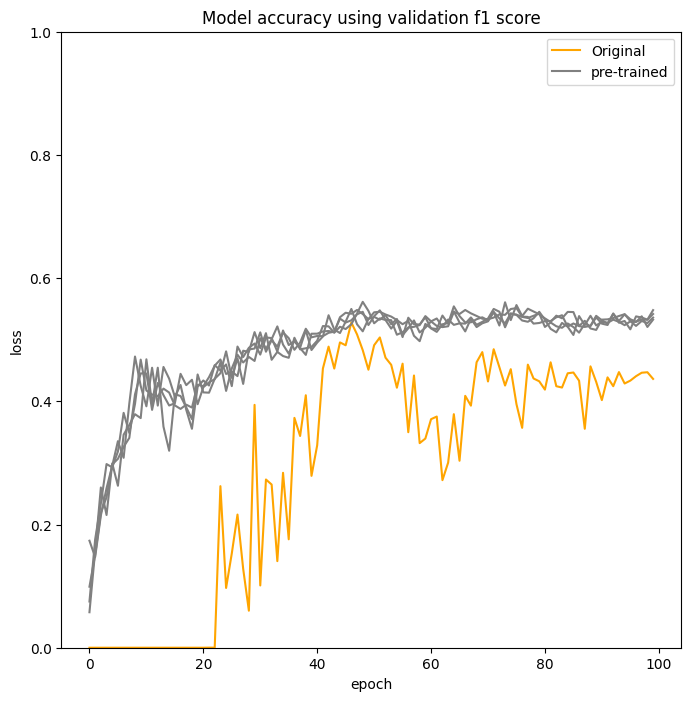

In [176]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]

plt.plot(result0.history['val_f1_m'],color="orange")
plt.plot(result_pretrained.history['val_f1_m'],color="grey")
plt.plot(result_pretrained_2.history['val_f1_m'],color="grey")
plt.plot(result_pretrained_3.history['val_f1_m'],color="grey")
plt.plot(result_pretrained_4.history['val_f1_m'],color="grey")

plt.title('Model accuracy using validation f1 score')
#

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Original', 'pre-trained'])
#plt.legend(['Original','Original val f1m', 'pre-trained f1m','pre-trained val f1m'], loc='upper right')
plt.ylim(0,1)
#plt.xlim(0,200)
plt.show()

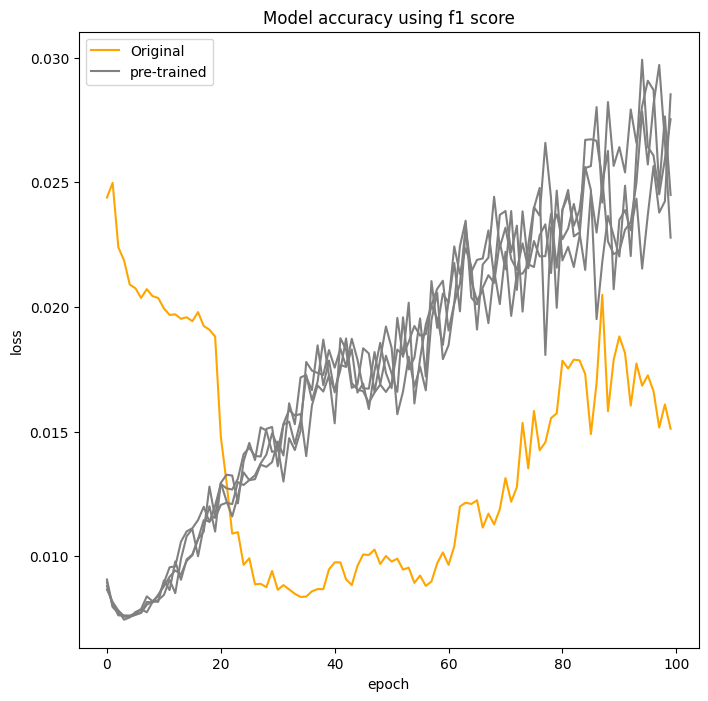

In [163]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]

plt.plot(result0.history['val_loss'],color="orange")
plt.plot(result_pretrained.history['val_loss'],color="grey")
plt.plot(result_pretrained_2.history['val_loss'],color="grey")
plt.plot(result_pretrained_3.history['val_loss'],color="grey")
plt.plot(result_pretrained_4.history['val_loss'],color="grey")

plt.title('Model accuracy using f1 score')
#

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Original', 'pre-trained'])
#plt.legend(['Original','Original val f1m', 'pre-trained f1m','pre-trained val f1m'], loc='upper right')

#plt.ylim(0,1)
#plt.xlim(0,200)
plt.show()

In [165]:
!python /workspace/code/semantic_segmentation/inference_unet.py -I /workspace/data/demo_area/topographical_indicies/hillshade /workspace/code/models/transfer_hillshade.h5 /workspace/data/demo_area/inference/inference_hillshade_pretrained

2023-05-08 17:36:30.895817: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 17:36:33.207977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-08 17:36:33.210221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-08 17:36:33.210372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning

In [169]:
import os
import numpy as np
import tifffile
from osgeo import gdal
import numpy as np
import sys
sys.path

from osgeo import gdal
from osgeo import osr


def write_gtiff(array, gdal_obj, outputpath, dtype=gdal.GDT_UInt16, options=0, color_table=0, nbands=1, nodata=False):
    """
    Writes a geotiff.

    array: numpy array to write as geotiff
    gdal_obj: object created by gdal.Open() using a tiff that has the SAME CRS, geotransform, and size as the array you're writing
    outputpath: path including filename.tiff
    dtype (OPTIONAL): datatype to save as. use gdal.GDT_Float32 for floating point and gdal.GDT_Byte for 4 bit int: https://gdal.org/drivers/raster/gtiff.html
    select from Byte, UInt16, Int16, UInt32, Int32, Float32, Float64, CInt16, CInt32, CFloat32 and CFloat64
    nodata (default: FALSE): set to any value you want to use for nodata; if FALSE, nodata is not set
    """

    gt = gdal_obj.GetGeoTransform()

    width = np.shape(array)[1]
    height = np.shape(array)[0]

    # Prepare destination file
    driver = gdal.GetDriverByName("GTiff")
    if options != 0:
        dest = driver.Create(outputpath, width, height, nbands, dtype, options)
    else:
        dest = driver.Create(outputpath, width, height, nbands, dtype)

    # Write output raster
    if color_table != 0:
        dest.GetRasterBand(1).SetColorTable(color_table)

    dest.GetRasterBand(1).WriteArray(array)

    if nodata is not False:
        dest.GetRasterBand(1).SetNoDataValue(nodata)

    # Set transform and projection
    dest.SetGeoTransform(gt)
    wkt = gdal_obj.GetProjection()
    srs = osr.SpatialReference()
    srs.ImportFromWkt(wkt)
    dest.SetProjection(srs.ExportToWkt())

    # Close output raster dataset
    dest = None


def patchify_x(img, start_y, patches, tile_size, margin, width):
    start_x = 0
    _, _, bands = img.shape
    while start_x + tile_size <= width:
        patches.append(img[start_y:start_y+tile_size,
                           start_x:start_x+tile_size, :].copy())
        # subtract own margin and margin of previous patch, so that margin of
        # previous patch is covered by the active area of the next patch
        start_x += tile_size - 2 * margin
        assert patches[-1].shape == (tile_size, tile_size, bands),\
            'shape: {}'.format(patches[-1].shape)
    # handle right boarder
    if start_x < width:
        start_x = width - tile_size
        patches.append(img[start_y:start_y+tile_size,
                           start_x:start_x+tile_size, :].copy())
        assert patches[-1].shape == (tile_size, tile_size, bands),\
            'shape: {}'.format(patches[-1].shape)


def patchify(img, tile_size, margin):
    patches = []

    height, width, bands = img.shape
    start_y = 0
    while start_y + tile_size <= height:
        patchify_x(img, start_y, patches, tile_size, margin, width)
        start_y += tile_size - 2 * margin
    # handle bottom boarder
    if start_y < height:
        start_y = height - tile_size
        patchify_x(img, start_y, patches, tile_size, margin, width)

    return patches


def start_and_end(base, tile_size, margin, limit, remainder):
    if base == 0:
        src_start = 0
        src_end = tile_size - margin
    elif base + (tile_size - margin) > limit:
        src_start = tile_size - remainder
        src_end = tile_size
    else:
        src_start = margin
        src_end = tile_size - margin

    return src_start, src_end


def unpatchify(shape, patches, tile_size, margin):
    img = np.zeros(shape[:-1])
    height, width, _ = shape
    remain_height = height % tile_size
    remain_width = width % tile_size

    dest_start_y = 0
    dest_start_x = 0

    for i, patch in enumerate(patches):
        remain_width = width - dest_start_x
        remain_height = height - dest_start_y
        src_start_y, src_end_y = start_and_end(dest_start_y, tile_size, margin,
                                               height, remain_height)
        src_start_x, src_end_x = start_and_end(dest_start_x, tile_size, margin,
                                               width, remain_width)
        y_length = src_end_y - src_start_y
        x_length = src_end_x - src_start_x
        img[dest_start_y:dest_start_y+y_length,
            dest_start_x:dest_start_x+x_length] = patch[src_start_y:src_end_y,
                                                        src_start_x:src_end_x]
        dest_start_x += x_length
        if dest_start_x >= width:
            dest_start_x = 0
            dest_start_y += y_length

    return img


def read_input(bands):
    '''Assemble input from list of provided tif files
       inputs will be added in order in which they are provided
    Parameters
    ----------
    bands : list of pathes to tif files
    Returns
    -------
    Tensor of shape (input height, input width, number of bands)
    '''
    tmp = tifffile.imread(bands[0])
    img = np.zeros([*tmp.shape, len(bands)])
    for i, band in enumerate(bands):
        tmp = tifffile.imread(band)
        tmp = tmp.astype(np.float32)
        img[:, :, i] = tmp

    return img


#def main(input_path, model_path, out_path, img_type, tile_size, margin,
#         threshold, wo_crf):
def main(img_path, model_path, out_path, img_type, tile_size, margin, 
         depth, class_num):
    #load model

    model = keras.models.load_model(model_path)# load old model
    
    # setup paths
    for path in img_path:
        if not os.path.exists(path):
            raise ValueError('Input path does not exist: {}'.format(path))
    # assume that either folder or image is given for all channels
    if os.path.isdir(img_path[0]):
        imgs = []
        for path in img_path:
            tmp = [os.path.join(path, f) for f in os.listdir(path)
                   if not f.startswith('._') and f.endswith('.tif')]
            imgs.append(tmp)
    else:
        imgs = [[f] for f in img_path]

    for bands in zip(*imgs):
        predicted = []

        img = read_input(bands)

        # we do not need to patchify image if image is too small to be split
        # into patches - assume that img width == img height
        do_patchify = True if tile_size < img.shape[0] else False

        if do_patchify:
            patches = patchify(img, tile_size, margin)
        else:
            patches = [img]

        # find suitable batch size
        for i in [8, 4, 2, 1]:
            if len(patches) % i == 0:
                bs = i
                break

        # perform prediction
        for i in range(0, len(patches), bs):
            batch = np.array(patches[i:i+bs])
            batch = batch.reshape((bs, *input_shape))
            out = model.predict(batch)
            for o in out:
                # choose id of output band with maximum probability
                tmp = np.argmax(o, axis=-1)
                predicted.append(tmp.reshape(input_shape[:-1]))

        if do_patchify:
            out = unpatchify(img.shape, predicted, tile_size, margin)
        else:
            out = predicted[0]

        # write image
        img_name = os.path.basename(bands[0]).split('.')[0]
        InutFileWithKnownExtent = gdal.Open(bands[0])
        utils.WriteGeotiff.write_gtiff(out, InutFileWithKnownExtent,
                                       os.path.join(out_path,
                                                    '{}.{}'.format(img_name,
                                                                   img_type)))




SyntaxError: invalid syntax (1203310635.py, line 222)

In [173]:
!python inference.py /workspace/data/demo_area/topographical_indicies/hillshade, /workspace/code/models/transfer_hillshade.h5, /workspace/data/demo_area/inference/inference_hillshade_pretrained